# Imported Modules

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as T

import os
import math as m
from PIL import Image as I
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
from ray.tune.search.optuna import OptunaSearch

# Model Initialization, Layer Replacement, Device Location

In [9]:
x = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in x.parameters():
    param.requires_grad = False

x.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(x.fc.weight, nonlinearity='relu')
x.fc.requires_grad = True

if torch.cuda.is_available():
    device = "cuda"
elif getattr(torch, 'has_mps', False):
    device = "mps"
else:
    device = "cpu"

x = x.to(device)

/var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_53838/4026304798.py:12: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif getattr(torch, 'has_mps', False):


# Unnormalization Class

In [10]:
class Unnormalize(object):
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# Data Loading Function

In [18]:
data_labels = {}
unnorm = Unnormalize()

def load_images():
    #Bunch of arrays for storing and moving data
    aux_img = []
    aux_labels = []
    train_imgs = []
    train_labels = []
    test_imgs = []
    test_labels = []
    val_imgs = []
    val_labels = []
    idx = 0

    crop = T.CenterCrop((128, 128))

    #Cycle through various folders for images
    for folder in range(len(sorted(os.listdir('./Data')))):
        if sorted(os.listdir('./Data'))[folder] == '.DS_Store':
            continue
        else:
            aux_img = os.listdir('./Data/'+sorted(os.listdir('./Data'))[folder])

            for i in range(len(aux_img)):
                #Remove .DS_Store file from data
                if aux_img[i] == '.DS_Store':
                    aux_img.pop(i)
                    break
            
            #Resize Image and Convert Channels
            for i in range(len(aux_img)):
                try:
                    with I.open('./Data/'+sorted(os.listdir('./Data'))[folder]+'/'+aux_img[i]) as img:
                        img = crop(img)

                        if img.mode != 'RGB':
                            img = img.convert('RGB')

                        img = np.array(img)
                        aux_img[i] = img
                except Exception as e:
                    print(f"{i}")
            aux_labels = []

            #Generate Labels
            for i in range(len(aux_img)):
                aux_labels.append(idx)
            idx += 1

            #Divide Data and Labels into Training, Testing, and Validation Sets
            train_imgs += aux_img[:int(m.ceil(len(aux_img)*0.6))]
            aux_img = aux_img[int(m.ceil(len(aux_img)*0.6)):]
            val_imgs += aux_img[:int(m.ceil(len(aux_img)*0.75))]
            aux_img = aux_img[int(m.ceil(len(aux_img)*0.75)):]
            test_imgs += aux_img

            train_labels += aux_labels[:int(m.ceil(len(aux_labels)*0.6))]
            aux_labels = aux_labels[int(m.ceil(len(aux_labels)*0.6)):]
            val_labels += aux_labels[:int(m.ceil(len(aux_labels)*0.75))]
            aux_labels = aux_labels[int(m.ceil(len(aux_labels)*0.75)):]
            test_labels += aux_labels
        data_labels[folder-1] = sorted(os.listdir('./Data'))[folder]

    #Data Normalization RGB -> [0, 1]
    aux_img = []
    aux_img = train_imgs + test_imgs + val_imgs
    mu = np.mean(aux_img, axis=(0, 1, 2))
    sigma = np.std(aux_img, axis=(0, 1, 2))
    unnorm.mean = mu
    unnorm.std = sigma

    normalize = T.Compose([
        T.Normalize(mu, sigma)
    ])

    #Conversion to tensors and recast data
    train_imgs, test_imgs, val_imgs = torch.tensor(train_imgs).to(torch.float32), torch.tensor(test_imgs).to(torch.float32), torch.tensor(val_imgs).to(torch.float32)
    train_labels, test_labels, val_labels = torch.tensor(train_labels), torch.tensor(test_labels), torch.tensor(val_labels)

    #Shuffle Images Sets
    train_imgs, train_labels = shuffle_imgs(train_imgs, train_labels)
    test_imgs, test_labels = shuffle_imgs(test_imgs, test_labels)
    val_imgs, val_labels = shuffle_imgs(val_imgs, val_labels)

    #Normalize and Reorder Data for Processing
    train_imgs = normalize(train_imgs.permute(0, 3, 1, 2))
    test_imgs = normalize(test_imgs.permute(0, 3, 1, 2))
    val_imgs = normalize(val_imgs.permute(0, 3, 1, 2))

    train_set, test_set, val_set = TensorDataset(train_imgs, train_labels), TensorDataset(test_imgs, test_labels), TensorDataset(val_imgs, val_labels)

    trainloader, testloader, valloader = DataLoader(dataset=train_set, shuffle=True, batch_size=128), DataLoader(dataset=test_set, shuffle=True, batch_size=64), DataLoader(dataset=val_set, shuffle=True, batch_size=64)

    return trainloader, testloader, valloader

#Shuffle Images according to Random Noise Generation
def shuffle_imgs(imgs, labels):
   B = imgs.size(0)
   shuffle = torch.randperm(B)
   return imgs[shuffle], labels[shuffle]

In [19]:
trainloader, testloader, valloader = load_images()
print(data_labels)

/var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_53838/1063623792.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  train_imgs, test_imgs, val_imgs = torch.tensor(train_imgs).to(torch.float32), torch.tensor(test_imgs).to(torch.float32), torch.tensor(val_imgs).to(torch.float32)


{0: 'apples', 1: 'coconuts', 2: 'grapes', 3: 'guavas', 4: 'lemons', 5: 'limes', 6: 'mango', 7: 'oranges', 8: 'peaches', 9: 'starfruit', 10: 'strawberries', 11: 'watermelons'}


# Train, Test, and Finetuning Functions

In [90]:
#Training Method with Adam Optimizer
def trainfunc(model, traindata, valdata, epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.006349288161821683, eps=6.5131448417080975e-09)
    #optimizer = optim.SGD(model.parameters(), lr=0.006349288161821683)
    lr_optim = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    loss_list = []
    loss_list_aux = []
    validation_loss = []
    validation_loss_aux = []

    for i in range(epochs):
        tot = 0
        div = 0
        for imgs, labels in traindata:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss_list_aux.append(loss.item())

            tot += (torch.argmax(logits, axis=1) == labels).float().sum().item()
            div += imgs.shape[0]

            loss.backward()
            optimizer.step()
        print('Training Accuracy (epoch ', i, '): ', tot/div*100, '%')
        print('Mean Training Loss: ', torch.mean(torch.tensor(loss_list_aux)))
        loss_list.append(torch.mean(torch.tensor(loss_list_aux)))
        lr_optim.step()

        with torch.no_grad():
            div = 0
            tot = 0
            for imgs, labels in valdata:
                imgs = imgs.to(device)
                labels = labels.to(device)
                val_logits = model(imgs)
                validation_loss_aux.append(F.cross_entropy(val_logits, labels).item())
                val_logits = nn.Softmax()(val_logits)
                pred = torch.argmax(val_logits, axis=1)
                tot += (pred == labels).float().sum().item()
                div += imgs.shape[0]
            validation_loss.append(torch.mean(torch.tensor(validation_loss_aux)))
            print('Mean Validation Loss: ', torch.mean(torch.tensor(validation_loss_aux)))
            print("Validation Accuracy: ", tot/div*100, "%")

    return model, loss_list, validation_loss

#Finetune Function
def finetune(model, data, valdata, epochs):
    model.fc.requires_grad = False
    model.avgpool.requires_grad = True
    model.layer4.requires_grad = True
    model.layer3.requires_grad = True
    model.layer2.requires_grad = True
    model.layer1.requires_grad = True
    model.maxpool.requires_grad = True
    model.conv1.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=2)
    loss_list = []
    loss_list_aux = []

    for i in range(epochs):
        for imgs, labels in data:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss_list_aux.append(loss.item())

            loss.backward()
            optimizer.step()
        
        loss_list.append(torch.mean(torch.tensor(loss_list_aux)))
        
        div = 0
        tot = 0
        for imgs, labels in valdata:
            imgs = imgs.to(device)
            labels = labels.to(device)
            val_logits = model(imgs)
            val_logits = nn.Softmax()(val_logits)
            pred = torch.argmax(val_logits, axis=1)
            tot += (pred == labels).float().sum().item()
            div += imgs.shape[0]
        print("Validation Accuracy: ", tot/div*100, "%")
        lr_sched.step()
    return model, loss_list

def test(model, data):
    div = 0
    total = 0

    for imgs, labels in data:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        logits = nn.Softmax()(logits)
        pred = torch.argmax(logits, axis=1)
        div += imgs.shape[0]
        total += (pred == labels).float().sum().item()
    print("Accuracy: ", total/div*100, "%")

# Confusion Matrix Function

In [44]:
def confusion_matrix(model, data):
    total_pred = []
    total_labels = []

    for imgs, labels in data:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        logits = nn.Softmax()(logits)
        pred = torch.argmax(logits, axis=1)

        total_pred += list(pred.to('cpu'))
        total_labels += list(labels.to('cpu'))

    con_mat = cm(total_labels, total_pred)
    labels = [data_labels[i] for i in range(len(con_mat))]
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(con_mat, annot=True, cmap="inferno", xticklabels=labels, yticklabels=labels)
    plt.title(f'ResNet50 Accuracy')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    plt.clf()

# Hyperparameter Tuning Functions

In [79]:
def hfinetunetrain(model, data, optimizer, lr_sched):
    for imgs, labels in data:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        optimizer.zero_grad()
        loss = F.cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()
        lr_sched.step()
    if device == "cuda":
        torch.cuda.empty_cache()
    elif device == "mps":
        torch.mps.empty_cache()

def hfinetunetest(model, data):
    model.eval()
    correct = 0
    total = 0

    for imgs, labels in data:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        
        pred = torch.argmax(outputs, axis=1)

        total += imgs.shape[0]
        correct += (pred == labels).float().sum().item()
    if device == "cuda":
        torch.cuda.empty_cache()
    elif device == "mps":
        torch.mps.empty_cache()
    return correct/total

def objective(config):
    train_loader, test_loader, val_loader = load_images()

    model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    for param in x.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(nn.Linear(2048, config["l1"]),
                                       nn.ReLU(),
                                       nn.Linear(config["l1"], config["l2"]),
                                       nn.ReLU(),
                                       nn.Linear(config["l2"], 12)
                                       ).to(device)
    nn.init.kaiming_uniform_(x.fc.weight, nonlinearity='relu')
    x.fc.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=config["lr"], eps=config["eps"])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_sched_step"])

    for epoch in range(10):
        hfinetunetrain(model, train_loader, optimizer, lr_sched)
        acc = hfinetunetest(model, val_loader)
        
        checkpoint = None
        if (epoch+1)%5 == 0:
            torch.save(model.state_dict(),
                       "Users/thomassigler/DeepLearningProject/TuningCheckpoints/model.pth")
            checkpoint = Checkpoint.from_directory("Users/thomassigler/DeepLearningProject/TuningCheckpoints")
        train.report({"mean_accuracy": acc}, checkpoint=checkpoint)

        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            torch.mps.empty_cache()

# Model Benchmark with Replaced Layer

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy:  8.108108108108109 %


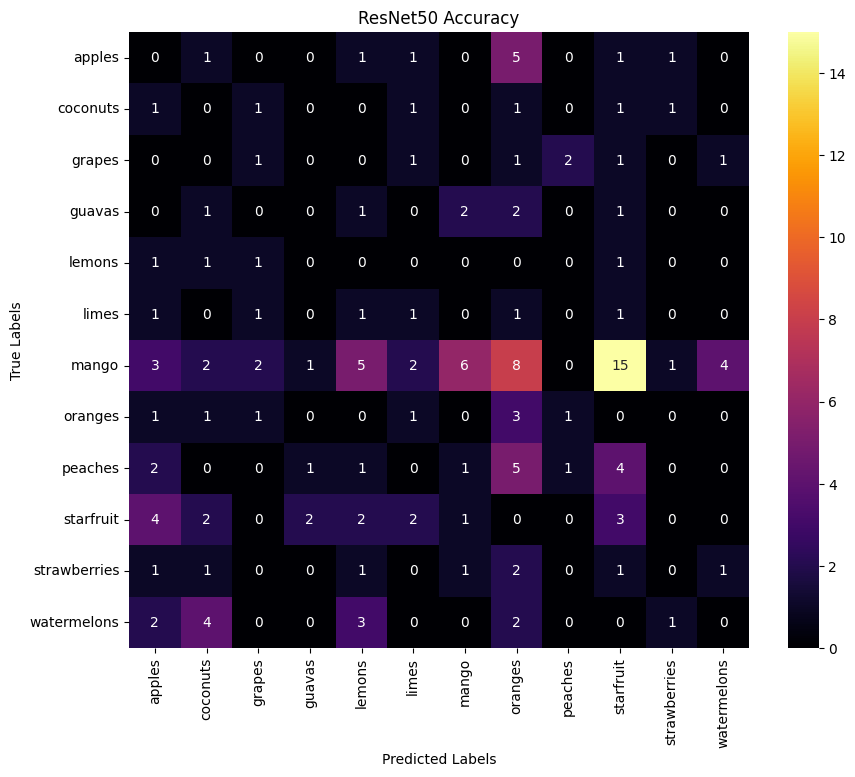

<Figure size 640x480 with 0 Axes>

In [46]:
test(x, testloader)

confusion_matrix(x, testloader)

# Training ResNet50 FC Layer

Training Accuracy (epoch  0 ):  36.67745415318231 %
Mean Training Loss:  tensor(1.8886)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Mean Validation Loss:  tensor(1.2270)
Validation Accuracy:  64.64208242950107 %
Training Accuracy (epoch  1 ):  84.46601941747572 %
Mean Training Loss:  tensor(1.3071)
Mean Validation Loss:  tensor(1.0424)
Validation Accuracy:  74.62039045553145 %
Training Accuracy (epoch  2 ):  91.8015102481122 %
Mean Training Loss:  tensor(0.9962)
Mean Validation Loss:  tensor(0.9315)
Validation Accuracy:  77.87418655097615 %
Training Accuracy (epoch  3 ):  96.87162891046385 %
Mean Training Loss:  tensor(0.8044)
Mean Validation Loss:  tensor(0.8995)
Validation Accuracy:  79.39262472885032 %
Training Accuracy (epoch  4 ):  98.70550161812298 %
Mean Training Loss:  tensor(0.6768)
Mean Validation Loss:  tensor(0.8583)
Validation Accuracy:  80.4772234273319 %
Training Accuracy (epoch  5 ):  99.67637540453075 %
Mean Training Loss:  tensor(0.5845)
Mean Validation Loss:  tensor(0.8309)
Validation Accuracy:  78.52494577006507 %
Training Accuracy (epoch  6 ):  100.0 %
Mean Training Loss:  tensor(0.5173)
Mean V

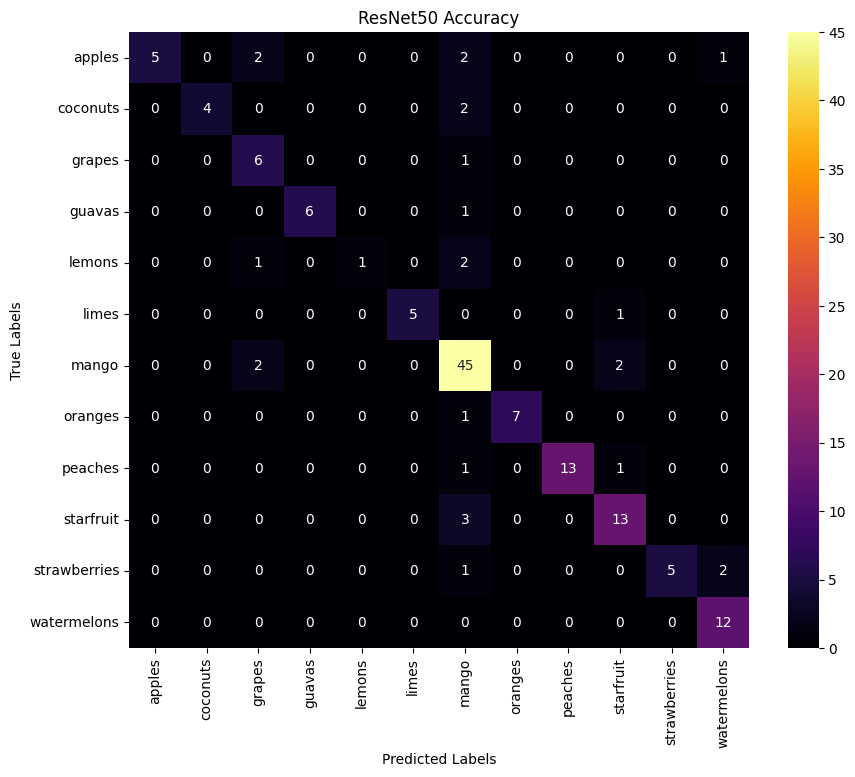

<Figure size 640x480 with 0 Axes>

In [94]:
x, loss_list, val_loss = trainfunc(x, trainloader, valloader, 200)
test(x, testloader)

confusion_matrix(x, testloader)

# Finetuning Pre-trained Layers

In [95]:
x, loss_list_val = finetune(x, valloader, valloader, 200)
test(x, testloader)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation Accuracy:  85.46637744034707 %
Validation Accuracy:  85.24945770065075 %
Validation Accuracy:  86.55097613882863 %
Validation Accuracy:  84.59869848156181 %
Validation Accuracy:  85.24945770065075 %
Validation Accuracy:  86.11713665943601 %
Validation Accuracy:  87.20173535791757 %
Validation Accuracy:  88.06941431670282 %
Validation Accuracy:  85.68329718004338 %
Validation Accuracy:  85.46637744034707 %
Validation Accuracy:  85.46637744034707 %
Validation Accuracy:  88.06941431670282 %
Validation Accuracy:  87.41865509761388 %
Validation Accuracy:  86.55097613882863 %
Validation Accuracy:  86.55097613882863 %
Validation Accuracy:  86.98481561822126 %
Validation Accuracy:  83.94793926247289 %
Validation Accuracy:  85.68329718004338 %
Validation Accuracy:  86.33405639913232 %
Validation Accuracy:  86.98481561822126 %
Validation Accuracy:  86.55097613882863 %
Validation Accuracy:  87.20173535791757 %
Validation Accuracy:  85.90021691973969 %
Validation Accuracy:  85.683297180

# Hyperparameter Tuning

Hyper-parameter tuning requires that all file path names in this script be their absolute path names. Otherwise, this portion of the program will crash. This is due to how Raytune runs its testing environment, which is in a different file from this script.

This protion of the script can be slow if CUDA is not used. There is 0 support for Apple Metal by Ray, so the cpu will be used for testing hyperparameters even if items are loaded to MPS.

Ray was built for Linux and Linux-based systems. Running this portion of the script on a Windows device can be difficult and has been a known issue since late 2023. This is due to a fix the library implemented for a Pyarrow 7+ bug.

In [ ]:
search_space = {"lr": tune.loguniform(1e-4, 1e-1), "eps": tune.loguniform(1e-10, 1e-6), "l1": tune.randint(50, 2049), "l2": tune.randint(12, 101), "lr_sched_step": tune.randint(1, 21)}
tuner = tune.Tuner(objective, tune_config=tune.TuneConfig(metric="mean_accuracy", mode="max", search_alg=OptunaSearch(), num_samples=2), param_space=search_space)

results = tuner.fit()
print("Best Config is: ", results.get_best_result().config)

(raylet) Warning: The actor ImplicitFunc is very large (90 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(objective pid=50259) /var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_51918/3592750841.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
(objective pid=50277) /var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_51918/3592750841.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
2024-04-22 18:10:08,284	WARNING util.py:202 -- The `on_step_begin` operation took 0.550 s, which may be a performance bottleneck.
(objective pid=50259) Checkpoint successfully created at: Checkp

Best Config is:  {'lr': 0.00023301901230003848, 'eps': 2.887185712485118e-09, 'l1': 1881, 'l2': 42, 'lr_sched_step': 6}


# Plotting Graphs

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


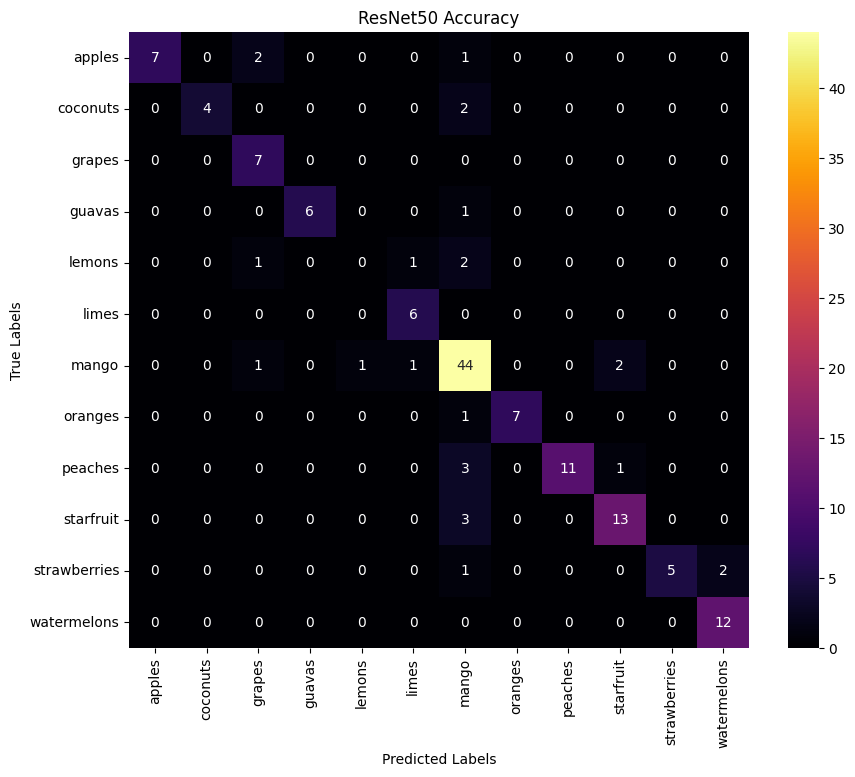

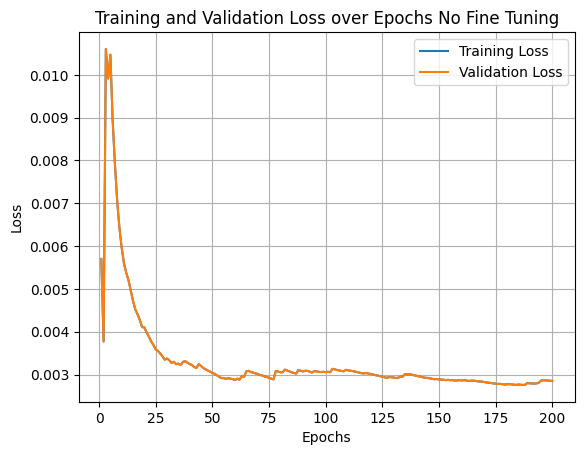

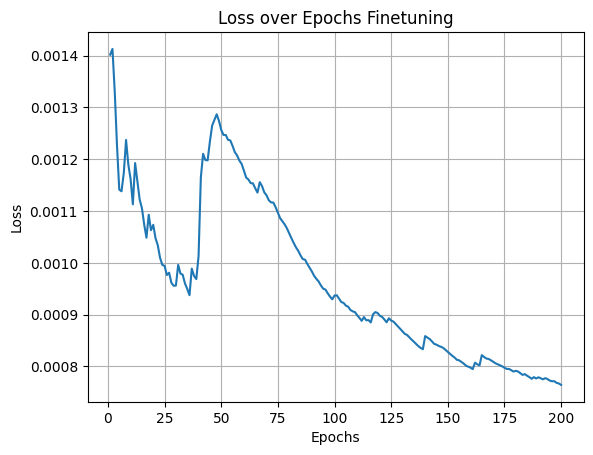

In [58]:
confusion_matrix(x, testloader)

plt.plot(np.linspace(1, len(loss_list), len(loss_list)), loss_list, label='Training Loss')
plt.plot(np.linspace(1, len(val_loss), len(loss_list)), loss_list, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs No Fine Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
plt.clf()

plt.plot(np.linspace(1, len(loss_list_val), len(loss_list_val)), loss_list_val)
plt.title('Loss over Epochs Finetuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
plt.clf()

# Optimizer Testing and Visualization

In [23]:
def optimizer_testing(data, model, optimizer, scheduler, val_data, epochs=100):
    model = model.to("mps")
    acc_list = []
    for epoch in range(epochs):
        count = 0
        total = 0
        for imgs, labels in data:
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            optimizer.step()
        scheduler.step()

        for imgs, labels in val_data:
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            optimizer.step()

            pred = torch.argmax(logits, axis=1)
            count += (pred == labels).float().sum().item()
            total += imgs.shape[0]

        acc_list.append(count/total*100)
    return acc_list


In [30]:
aux_model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in aux_model.parameters():
    param.requires_grad = False

aux_model.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(aux_model.fc.weight, nonlinearity='relu')
aux_model.fc.requires_grad = True
optimizer = torch.optim.Adam(aux_model.parameters(), lr=0.01)
Adam_list_1 = optimizer_testing(trainloader, aux_model, optimizer, optim.lr_scheduler.StepLR(optimizer, step_size=1), valloader)
print("Done - 1")
aux_model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in aux_model.parameters():
    param.requires_grad = False

aux_model.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(aux_model.fc.weight, nonlinearity='relu')
aux_model.fc.requires_grad = True
optimizer = torch.optim.Adam(aux_model.parameters(), lr=0.01)
Adam_list_2 = optimizer_testing(trainloader, aux_model, optimizer, optim.lr_scheduler.StepLR(optimizer, step_size=2), valloader)
print("Done - 2")
aux_model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in aux_model.parameters():
    param.requires_grad = False

aux_model.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(aux_model.fc.weight, nonlinearity='relu')
aux_model.fc.requires_grad = True
optimizer = torch.optim.Adam(aux_model.parameters(), lr=0.01)
Adam_list_3 = optimizer_testing(trainloader, aux_model, optimizer, optim.lr_scheduler.StepLR(optimizer, step_size=3), valloader)
print("Done - 3")
aux_model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in aux_model.parameters():
    param.requires_grad = False

aux_model.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(aux_model.fc.weight, nonlinearity='relu')
aux_model.fc.requires_grad = True
optimizer = torch.optim.Adam(aux_model.parameters(), lr=0.01)
Adam_list_4 = optimizer_testing(trainloader, aux_model, optimizer, optim.lr_scheduler.StepLR(optimizer, step_size=4), valloader)
print("Done - 4")
aux_model = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in aux_model.parameters():
    param.requires_grad = False

aux_model.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(aux_model.fc.weight, nonlinearity='relu')
aux_model.fc.requires_grad = True
optimizer = torch.optim.Adam(aux_model.parameters(), lr=0.01)
Adam_list_5 = optimizer_testing(trainloader, aux_model, optimizer, optim.lr_scheduler.StepLR(optimizer, step_size=5), valloader)
print("Done - 5")

Done - 1
Done - 2
Done - 3
Done - 4
Done - 5


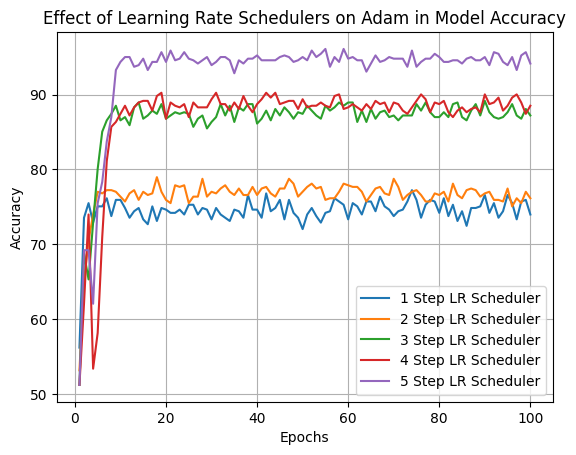

<Figure size 640x480 with 0 Axes>

In [31]:
plt.clf()
plt.plot(np.linspace(1, len(Adam_list_1), len(Adam_list_1)), Adam_list_1, label="1 Step LR Scheduler")
plt.plot(np.linspace(1, len(Adam_list_2), len(Adam_list_2)), Adam_list_2, label="2 Step LR Scheduler")
plt.plot(np.linspace(1, len(Adam_list_1), len(Adam_list_1)), Adam_list_3, label="3 Step LR Scheduler")
plt.plot(np.linspace(1, len(Adam_list_1), len(Adam_list_1)), Adam_list_4, label="4 Step LR Scheduler")
plt.plot(np.linspace(1, len(Adam_list_1), len(Adam_list_1)), Adam_list_5, label="5 Step LR Scheduler")
plt.title("Effect of Learning Rate Schedulers on Adam in Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
plt.clf()